In [ ]:
!pip install -q datasets pandas underthesea sentence-transformers

In [ ]:
!pip install -q hdbscan scikit-learn matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import load_dataset
import pandas as pd

# Load dataset
qa_dataset = load_dataset("hungnm/vietnamese-medical-qa")
df = pd.DataFrame(qa_dataset["train"])
df

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,answer,question
0,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nRăng cháu hiện tại có mủ ở dưới ..."
1,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nEm thấy mặt dưới, phía cuống lưỡ..."
2,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nTừ tháng 4/2020, em mới xuất hiệ..."
3,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nDạo gần đây, mỗi tối ngủ con hay..."
4,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nEm bị tăng tiết mồ hôi, nhất là ..."
...,...,...
9330,Đây là 1 triệu chứng của rất nhiều loại bệnh. ...,Tôi hay bị đau đầu về đêm xin được tư vấn cách...
9331,Chào bạn. \nKhông rõ bé nhà bạn lúc sinh được ...,"Xin chào bác sĩ,\nBé nhà tôi 6 tháng tuổi hay ..."
9332,Chào bạn!\nTình trạng nổi mụn của bạn có thể d...,"Xin chào bác sĩ,\nEm năm nay 23t... hồi trước ..."
9333,Chào bạn\nHiện nay trên thị trường có rất nhiề...,"Xin chào bác sĩ, tôi muốn được tư vấn về loại ..."


In [ ]:
import re, unicodedata, pandas as pd

# Regex emoji
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F1E0-\U0001F1FF"  # flags
    "\U00002700-\U000027BF"  # dingbats
    "\U0001F900-\U0001F9FF"  # supplemental symbols
    "]+", flags=re.UNICODE)

# Regex chỉ giữ chữ cái tiếng Việt + khoảng trắng
non_allowed = re.compile(r"[^A-Za-zÀ-Ỹà-ỹ\s]")

def preprocess(text):
    if pd.isna(text):
        return ""

    s = unicodedata.normalize("NFC", str(text)).lower()

    # Xoá emoji
    s = emoji_pattern.sub(" ", s)

    # Bỏ mấy cụm chào bác sĩ/dược sĩ
    s = re.sub(r"\b(chào|thưa)\s+(sĩ|bs|bác sĩ|dược sĩ)\b", " ", s)

    # Xoá ký tự không hợp lệ
    s = non_allowed.sub(" ", s)

    # Gom khoảng trắng
    s = " ".join(s.split())
    return s

df["question_cleaned"] = df["question"].apply(preprocess)
print(df.shape)
df


(9335, 3)


,answer,question,question_cleaned
0,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nRăng cháu hiện tại có mủ ở dưới ...",răng cháu hiện tại có mủ ở dưới lợi nhưng khi ...
1,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nEm thấy mặt dưới, phía cuống lưỡ...",em thấy mặt dưới phía cuống lưỡi của mình có n...
2,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nTừ tháng 4/2020, em mới xuất hiệ...",từ tháng em mới xuất hiện lần đầu triệu chứng ...
3,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nDạo gần đây, mỗi tối ngủ con hay...",dạo gần đây mỗi tối ngủ con hay bị nghẹt mũi k...
4,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nEm bị tăng tiết mồ hôi, nhất là ...",em bị tăng tiết mồ hôi nhất là vùng mặt và ngự...
...,...,...,...
9330,Đây là 1 triệu chứng của rất nhiều loại bệnh. ...,Tôi hay bị đau đầu về đêm xin được tư vấn cách...,tôi hay bị đau đầu về đêm xin được tư vấn cách...
9331,Chào bạn. \nKhông rõ bé nhà bạn lúc sinh được ...,"Xin chào bác sĩ,\nBé nhà tôi 6 tháng tuổi hay ...",xin bé nhà tôi tháng tuổi hay bị nôn trớ bé nô...
9332,Chào bạn!\nTình trạng nổi mụn của bạn có thể d...,"Xin chào bác sĩ,\nEm năm nay 23t... hồi trước ...",xin em năm nay t hồi trước ít mụn lắm nhưng từ...
9333,Chào bạn\nHiện nay trên thị trường có rất nhiề...,"Xin chào bác sĩ, tôi muốn được tư vấn về loại ...",xin tôi muốn được tư vấn về loại thuốc tăng kí...


In [ ]:
from underthesea import word_tokenize

# Load stopwords
reference_stwrds = "/content/drive/MyDrive/NLP/Data/vietnamese-stopwords.txt"
with open(reference_stwrds, "r", encoding="utf-8") as file:
    vn_stopwords = set(w.strip().lower() for w in file.read().splitlines() if w.strip())

# Tokenize + bỏ stopwords
def tokenize_remove_stopwords(text):
    tokens = word_tokenize(str(text), format="text").split()  # tokenize thành list
    tokens = [w for w in tokens if w.lower() not in vn_stopwords]
    return " ".join(tokens)

# Tạo cột mới
df["question_processed"] = df["question_cleaned"].apply(tokenize_remove_stopwords)

print(df.shape)
df

(9335, 4)


,answer,question,question_cleaned,question_processed
0,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nRăng cháu hiện tại có mủ ở dưới ...",răng cháu hiện tại có mủ ở dưới lợi nhưng khi ...,mủ lợi đau ngủ đau đau bảo đau_răng dậy_thì đa...
1,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nEm thấy mặt dưới, phía cuống lưỡ...",em thấy mặt dưới phía cuống lưỡi của mình có n...,mặt cuống_lưỡi nốt mụn đỏ xung_quanh nhân_trắn...
2,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nTừ tháng 4/2020, em mới xuất hiệ...",từ tháng em mới xuất hiện lần đầu triệu chứng ...,đầu triệu_chứng viêm amidan mủ sốt trở bệnh tá...
3,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nDạo gần đây, mỗi tối ngủ con hay...",dạo gần đây mỗi tối ngủ con hay bị nghẹt mũi k...,dạo tối ngủ nghẹt mũi kèm vướng_họng đờm nằm_x...
4,"Chào bạn,\nĐể trả lời câu hỏi trên, bác sĩ xin...","Chào bác sĩ,\nEm bị tăng tiết mồ hôi, nhất là ...",em bị tăng tiết mồ hôi nhất là vùng mặt và ngự...,tiết mồ_hôi mặt ngực tiết mồ_hôi mặt ngực
...,...,...,...,...
9330,Đây là 1 triệu chứng của rất nhiều loại bệnh. ...,Tôi hay bị đau đầu về đêm xin được tư vấn cách...,tôi hay bị đau đầu về đêm xin được tư vấn cách...,đau_đầu
9331,Chào bạn. \nKhông rõ bé nhà bạn lúc sinh được ...,"Xin chào bác sĩ,\nBé nhà tôi 6 tháng tuổi hay ...",xin bé nhà tôi tháng tuổi hay bị nôn trớ bé nô...,nôn_trớ nôn nôn_bé tăng_động cao_cm mhư bình_t...
9332,Chào bạn!\nTình trạng nổi mụn của bạn có thể d...,"Xin chào bác sĩ,\nEm năm nay 23t... hồi trước ...",xin em năm nay t hồi trước ít mụn lắm nhưng từ...,hồi mụn lắm tết mụn mọc má đỏ ửng mụn_bọc mụn ...
9333,Chào bạn\nHiện nay trên thị trường có rất nhiề...,"Xin chào bác sĩ, tôi muốn được tư vấn về loại ...",xin tôi muốn được tư vấn về loại thuốc tăng kí...,thuốc kích_thước dương_vật tác_dụng sinh_lí kí...


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load model SBERT cho tiếng Việt
model_name = "keepitreal/vietnamese-sbert"
model = SentenceTransformer(model_name)

texts = df["question_processed"].astype(str).tolist()
embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

# Chuẩn hóa vector (L2 normalize) để clustering hiệu quả hơn
from sklearn.preprocessing import normalize
embeddings = normalize(embeddings, norm='l2')

print("Embeddings shape:", embeddings.shape)
np.save("/content/drive/MyDrive/NLP/embeddings_sbert.npy", embeddings)

Batches:   0%|          | 0/146 [00:00<?, ?it/s]

Embeddings shape: (9335, 768)


In [ ]:
from sklearn.cluster import KMeans
import hdbscan
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
wcss = []
K_range = range(2, 100)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

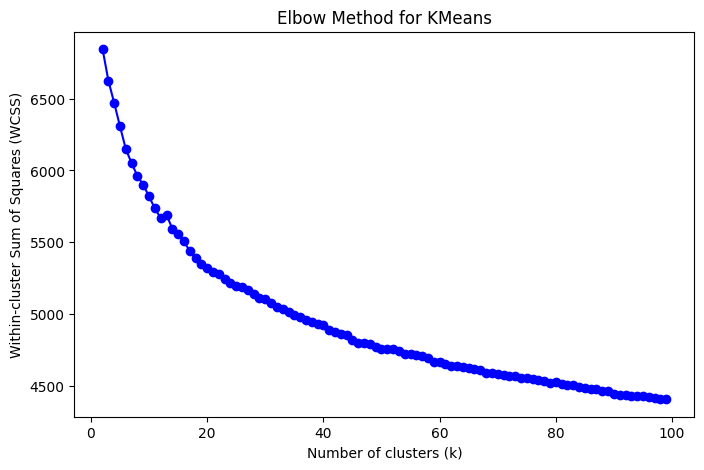

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for KMeans")
plt.show()

In [ ]:
k_opt = 18
kmeans = KMeans(n_clusters=k_opt, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings)
print("KMeans silhouette score:", silhouette_score(embeddings, kmeans_labels))
print("KMeans cluster counts:")
print(pd.Series(kmeans_labels).value_counts())

KMeans silhouette score: 0.052510668
KMeans cluster counts:
0     744
2     738
8     701
10    687
12    668
11    605
15    604
3     586
13    523
5     502
4     454
9     450
1     432
7     383
17    381
16    375
14    334
6     168
Name: count, dtype: int64


In [ ]:
# LẤY TOP KEYWORDS CHO MỖI CỤM KMEANS
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def cluster_names(labels, texts, top_n=5):
    vect = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
    X = vect.fit_transform(texts)
    feat = vect.get_feature_names_out()
    labs = np.array(labels)
    names = {}
    for lab in np.unique(labs):
        idx = np.where(labs == lab)[0]
        if idx.size == 0:
            continue
        mean_tf = np.asarray(X[idx].mean(axis=0)).ravel()
        top_idx = mean_tf.argsort()[::-1][:top_n]
        keywords = [feat[i] for i in top_idx if mean_tf[i] > 0]
        names[int(lab)] = ", ".join(keywords) if keywords else "(no keywords)"
    return names

# Lấy tên cụm từ KMeans
kmeans_names = cluster_names(kmeans_labels, df["question_processed"].astype(str).tolist(), top_n=5)

# In kết quả
print("KMEANS cluster names:")
for k in sorted(kmeans_names):
    print("Topic", k, ":", kmeans_names[k])


KMEANS cluster names:
Topic 0 : mổ, phẫu_thuật, thận, cắt, sỏi
Topic 1 : tiểu, đi_tiểu, dương_vật, xuất_tinh, bệnh
Topic 2 : thuốc, uống, tiêm, uống thuốc, bệnh
Topic 3 : sữa, uống, mẹ, bổ_sung, ăn_uống
Topic 4 : đau, bụng, ngực, đau bụng, dạ_dày
Topic 5 : đau, hàm, nhổ, sưng, mọc
Topic 6 : thuoc, dau, benh, gi, tuoi
Topic 7 : quan_hệ, kinh_nguyệt, kinh, thai, gái
Topic 8 : mụn, da, ngứa, nổi, đỏ
Topic 9 : thai, tuần, có_thai, vợ, bầu
Topic 10 : đau_đầu, đầu, đau, chóng_mặt, bệnh
Topic 11 : xét_nghiệm, chỉ_số, máu, kết_quả, gan
Topic 12 : tóc, rụng, mồ_hôi, bệnh, mong
Topic 13 : đau, chân, khớp, xương, bệnh
Topic 14 : mũi, viêm, tai, xoang, chảy
Topic 15 : ho, họng, đờm, viêm, thở
Topic 16 : mắt, đỏ, kính, mổ, mờ
Topic 17 : ngủ, mất_ngủ, dậy, giấc_ngủ, tối


In [ ]:
!pip install -q bertopic umap-learn

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from umap import UMAP
import hdbscan
import numpy as np
import pandas as pd

# UMAP để giảm chiều embeddings
umap_model = UMAP(
    n_neighbors=50,
    n_components=3,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# HDBSCAN cho clustering
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=50,
    metric='euclidean',
    cluster_selection_method='eom'
)

vectorizer_model = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# BERTopic
topic_model = BERTopic(
    embedding_model=None,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=100,
    top_n_words=5,
    verbose=True
)

topics, probs = topic_model.fit_transform(
    df["question_processed"].astype(str).tolist(),
    embeddings=embeddings
)

# Hàm lấy tên topic theo TF-IDF
def bertopic_cluster_names(topic_labels, texts, top_n=5):
    vect = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
    X = vect.fit_transform(texts)
    feat = vect.get_feature_names_out()
    names = {}
    for t in np.unique(topic_labels):
        if t == -1:  # bỏ noise
            continue
        idx = np.where(topic_labels == t)[0]
        mean_tf = np.asarray(X[idx].mean(axis=0)).ravel()
        top_idx = mean_tf.argsort()[::-1][:top_n]
        keywords = [feat[i] for i in top_idx if mean_tf[i] > 0]
        names[int(t)] = ", ".join(keywords) if keywords else "(no keywords)"
    return names

names = bertopic_cluster_names(topics, df["question_processed"].astype(str).tolist(), top_n=5)

# In kết quả
print("BERTopic cluster names (noise -1 omitted):")
for t in sorted(names):
    print(f"Topic {t} : {names[t]}")

# Xem số lượng mỗi topic
topic_counts = pd.Series(topics).value_counts()
print("\nTopic counts:")
print(topic_counts)

2025-10-02 11:50:38,408 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-02 11:51:50,612 - BERTopic - Dimensionality - Completed ✓
2025-10-02 11:51:50,614 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-02 11:51:51,156 - BERTopic - Cluster - Completed ✓
2025-10-02 11:51:51,166 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-02 11:51:52,317 - BERTopic - Representation - Completed ✓


BERTopic cluster names (noise -1 omitted):
Topic 0 : thai, quan_hệ, thuốc, kinh_nguyệt, kinh
Topic 1 : mụn, da, ngứa, nổi, đỏ
Topic 2 : ho, họng, đờm, viêm, thuốc
Topic 3 : đau, chân, khớp, xương, gãy
Topic 4 : xét_nghiệm, gan, chỉ_số, máu, kết_quả
Topic 5 : đau, bụng, ngực, dạ_dày, đau bụng
Topic 6 : mắt, đỏ, mổ, kính, mắt đỏ
Topic 7 : đau_đầu, đầu, đau, chóng_mặt, nửa đầu
Topic 8 : sữa, mẹ, uống, uống sữa, ăn_dặm
Topic 9 : nhổ, mọc, đau, hàm, sâu
Topic 10 : giáp, phổi, tuyến, tuyến giáp, thùy
Topic 11 : ngủ, mất_ngủ, trầm_cảm, giấc_ngủ, suy_nghĩ
Topic 12 : mũi, viêm, xoang, chảy, viêm xoang
Topic 13 : tiểu, đi_tiểu, nước_tiểu, bàng_quang, đau
Topic 14 : thuoc, gi, dau, benh, tuoi
Topic 15 : thận, sỏi, sỏi thận, niệu_quản, suy
Topic 16 : tiêm, mũi, vắc_xin, tiêm vắc_xin, covid
Topic 17 : vitamin, uống, bổ_sung, bổ_sung vitamin, vitamin_e
Topic 18 : tiểu_đường, đường_huyết, glucose, chỉ_số, bệnh tiểu_đường
Topic 19 : tai, ù_tai, viêm tai, tiếng, nhĩ

Topic counts:
-1     2921
 0     10

In [ ]:
# Lấy DataFrame thông tin topic cho từng document
doc_info = topic_model.get_document_info(df["question_processed"].astype(str).tolist())
topic_records = doc_info[doc_info["Topic"] == 14][["Document", "Topic", "Probability"]]
topic_records


,Document,Topic,Probability
5085,hỏi_la e_dang covid ma bệnh e_test vạch voi la...,14,0.203362
5966,thua e_cam hệ miễn_dịch yếu_e xet nghiêm_gi hệ...,14,0.347243
6052,sỹ giup voi chồng set_nghiệm sỹ noi kích_thước...,14,0.094746
6071,màu cach gi trắng sy,14,1.000000
6129,e_hoi kết_quả,14,1.000000
...,...,...,...
9188,lở áp xe ngực co bao_lau áp xe nguyen nhan_thua,14,0.312953
9229,di_sieu am_bs noi bi da_nang buong trung_nhung...,14,0.785870
9231,ban bj tai_nan tinh_den da nam_roi bay gio thi...,14,0.609762
9295,bi_đau đau vi_tri đau_la hai gay_va vung tiêu_...,14,0.280821
